In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from pytorchtools import EarlyStopping
import matplotlib.pyplot as plt


# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
batch_size = 16
num_epochs = 100
lr = 0.0001

In [10]:
# Generate some random training data
data = pd.read_csv('ioperf.csv')
X = data[['bandwidth', 'chunkSize', 'iomode']].to_numpy()
X = MinMaxScaler().fit_transform(X)
y = data['latency'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Convert the data to PyTorch tensors and create a Dataset
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# Create DataLoaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Validation loss decreased (inf --> 0.002478).  Saving model ...
Validation loss decreased (0.002478 --> 0.000400).  Saving model ...
Validation loss decreased (0.000400 --> 0.000052).  Saving model ...
Validation loss decreased (0.000052 --> 0.000033).  Saving model ...
Validation loss decreased (0.000033 --> 0.000016).  Saving model ...
Validation loss decreased (0.000016 --> 0.000001).  Saving model ...
Validation loss decreased (0.000001 --> 0.000001).  Saving model ...
Validation loss decreased (0.000001 --> 0.000001).  Saving model ...
Validation loss decreased (0.000001 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Early stopping


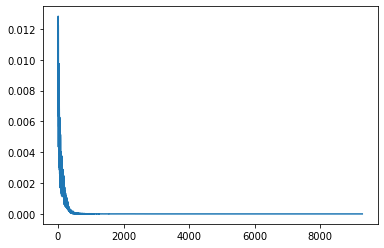

In [11]:
# Initialize the training and test history lists
train_history = []

# Create an instance of the MLP model
model = MLP()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define the early stopping utility
early_stopping = EarlyStopping(patience=10, verbose=True)

# define the file path to save the model state
checkpoint_path = 'model.pth'

best_val_loss = 1e9
# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        train_history.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        # Compute the test loss
        for inputs, targets in val_dataloader:
            outputs = model(inputs.float())
            val_loss = criterion(outputs, targets.float())

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # define the checkpoint dictionary containing the model state and optimizer state
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)
        
    # Check for early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {val_loss.item():.4f}")

plt.plot(train_history)

Test Loss: 0.0000


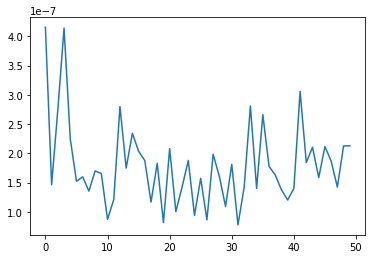

In [24]:
test_history = []

# load the checkpoint from a file
checkpoint = torch.load(checkpoint_path)
# load the state of the model and optimizer from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

err = []
# Test the trained model
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        test_history.append(loss)

    print(f"Test Loss: {loss.item():.4f}")

plt.plot(test_history)